<a href="https://colab.research.google.com/github/amilkh/cs230-fer/blob/transfer-learning/Final-ResNet50-ClassWeight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x
!pip install keras-vggface
!pip install scikit-image
!pip install pydot

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.python.lib.io import file_io

%matplotlib inline

import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface.vggface import VGGFace
from keras.utils import plot_model
from sklearn.metrics import *
from keras.engine import Model
from keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPool2D, BatchNormalization, Dropout, MaxPooling2D
import skimage
from skimage.transform import rescale, resize

import pydot

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
print(tf.__version__)
print(keras.__version__)

1.15.0
2.2.5


In [0]:
EPOCHS = 50
BS = 128
DROPOUT_RATE = 0.5
FROZEN_LAYER_NUM = 170

ADAM_LEARNING_RATE = 0.001
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

Resize_pixelsize = 197

In [6]:
vgg_notop = VGGFace(model='resnet50', include_top=False, input_shape=(Resize_pixelsize, Resize_pixelsize, 3), pooling='avg')
last_layer = vgg_notop.get_layer('avg_pool').output
x = Flatten(name='flatten')(last_layer)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(4096, activation='relu', name='fc6')(x)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(1024, activation='relu', name='fc7')(x)
x = Dropout(DROPOUT_RATE)(x)
# l=0
# for layer in vgg_notop.layers:
#     print(layer,"["+str(l)+"]")
#     l=l+1
    
batch_norm_indices = [2, 6, 9, 13, 14, 18, 21, 24, 28, 31, 34, 38, 41, 45, 46, 53, 56, 60, 63, 66, 70, 73, 76, 80, 83, 87, 88, 92, 95, 98, 102, 105, 108, 112, 115, 118, 122, 125, 128, 132, 135, 138, 142, 145, 149, 150, 154, 157, 160, 164, 167, 170]
for i in range(FROZEN_LAYER_NUM):
    if i not in batch_norm_indices:
        vgg_notop.layers[i].trainable = False
# print('vgg layer 2 is trainable: ' + str(vgg_notop.layers[2].trainable))
# print('vgg layer 3 is trainable: ' + str(vgg_notop.layers[3].trainable))

out = Dense(7, activation='softmax', name='classifier')(x)

model = Model(vgg_notop.input, out)


optim = keras.optimizers.Adam(lr=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optim = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = keras.optimizers.SGD(lr=SGD_LEARNING_RATE, momentum=0.9, decay=SGD_DECAY, nesterov=True)
rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_acc',mode='max',factor=0.5, patience=10, min_lr=0.00001, verbose=1)

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
# plot_model(model, to_file='model2.png', show_shapes=True)














94699520/94694792 [==============================] - 1s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [0]:
! rm -rf train; mkdir train
! unzip -q '/content/drive/My Drive/cs230 project/dataset/emotion.zip' -d train
! unzip -q '/content/drive/My Drive/cs230 project/dataset/facesdb.zip' -d train
! unzip -q '/content/drive/My Drive/cs230 project/dataset/fer2013/train.zip' -d train
! unzip -q '/content/drive/My Drive/cs230 project/dataset/googlesearch.zip' -d train
! unzip -q '/content/drive/My Drive/cs230 project/dataset/googleset.zip' -d train
! unzip -q '/content/drive/My Drive/cs230 project/dataset/jaffe.zip' -d train
! unzip -q '/content/drive/My Drive/cs230 project/dataset/umea.zip' -d train

In [0]:
! rm -rf dev; mkdir dev
! unzip -q '/content/drive/My Drive/cs230 project/dataset/fer2013/test-public.zip' -d dev
! rm -rf test; mkdir test
! unzip -q '/content/drive/My Drive/cs230 project/dataset/fer2013/test-private.zip' -d test

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_datagen(dataset, aug=False):
    if aug:
        datagen = ImageDataGenerator(
                            rescale=1./255,
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True)
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    return datagen.flow_from_directory(
            dataset,
            target_size=(197, 197),
            color_mode='rgb',
            shuffle = True,
            class_mode='categorical',
            batch_size=BS)

In [10]:
train_generator  = get_datagen('/content/train', True)
dev_generator    = get_datagen('/content/dev')
test_generator  = get_datagen('/content/test')


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:173: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 30452 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [0]:
from sklearn.utils import class_weight
file_stream = file_io.FileIO('/content/drive/My Drive/cs230 project/collab/fer2013/dev.csv', mode='r')
data = pd.read_csv(file_stream)
data[' pixels'] = data[' pixels'].apply(lambda x: [int(pixel) for pixel in x.split()])
X, Y = data[' pixels'].tolist(), data['emotion'].values
class_weights = class_weight.compute_class_weight('balanced',
                                                    np.unique(Y),
                                                    Y)


In [12]:
history = model.fit_generator(
    generator = train_generator,
    validation_data=dev_generator, 
    steps_per_epoch=28709// BS,
    validation_steps=3509 // BS,
    shuffle=True,
    epochs=100,
    callbacks=[rlrop],
    use_multiprocessing=True,
    class_weight=class_weights
) 

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
224/224 [==============================] - 289s 1s/step - loss: 1.9871 - acc: 0.3442 - val_loss: 1.3152 - val_acc: 0.5000
Epoch 2/100
224/224 [==============================] - 281s 1s/step - loss: 1.3912 - acc: 0.4737 - val_loss: 1.1570 - val_acc: 0.5734
Epoch 3/100
224/224 [==============================] - 280s 1s/step - loss: 1.2821 - acc: 0.5175 - val_loss: 1.1171 - val_acc: 0.5929
Epoch 4/100
224/224 [==============================] - 282s 1s/step - loss: 1.2177 - acc: 0.5430 - val_loss: 1.0938 - val_acc: 0.5875
Epoch 5/100
224/224 [==============================] - 282s 1s/step - loss: 1.1654 - acc: 0.5644 - val_loss: 1.0511 - val_acc: 0.6157
Epoch 6/100
224/224 [==============================] - 282s 1s/step - loss: 1.1429 - acc: 0.5725 - val_loss: 1.0393 - val_acc: 0.6109
Epoch 7/100
224/224 [==============================] - 282s 1s/step - loss: 1.1071 - acc: 0.5876 - v

In [13]:
print('\n# Evaluate on dev data')
results_dev = model.evaluate_generator(dev_generator, 3509 // BS)
print('dev loss, dev acc:', results_dev)


# Evaluate on dev data
dev loss, dev acc: [0.8531583790425901, 0.7071759259259259]


In [14]:
print('\n# Evaluate on test data')
results_test = model.evaluate_generator(test_generator, 3509 // BS)
print('test loss, test acc:', results_test)


# Evaluate on test data
test loss, test acc: [0.7922037023085134, 0.7239583333333334]


dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


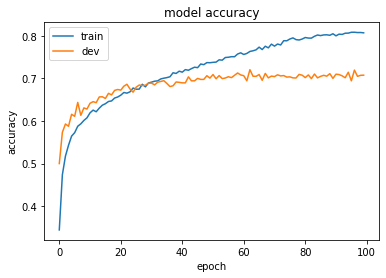

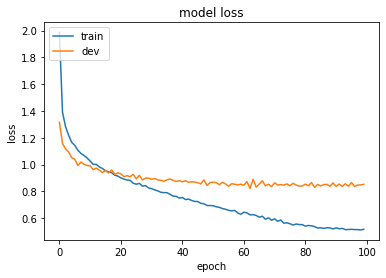

In [15]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [0]:
epoch_str = '-EPOCHS_' + str(EPOCHS)
test_acc = 'test_acc_%.3f' % results_test[1]
model.save('/content/drive/My Drive/cs230 project/models/' + 'RESNET50-Class-Weights' + epoch_str + test_acc + '.h5')